# Sentiment Analysis - CP322
---
Riley Huston (190954880) | Samson Goodenough (190723380) | Shailendra Singh ()

## Section 1 | Setup

In [2]:
# import libraries
import nltk
import pandas as pd
import sklearn
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns


# training
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# visualization
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

# download dependenciesquirements
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('treebank')
nltk.download('tagsets')
nltk.download('vader_lexicon')

print('Finished downloading')

Finished downloading


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrrjh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mrrjh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrrjh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mrrjh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mrrjh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mrrjh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_d

## Section 2 | Preprocessing

In [3]:
# import data
df = pd.read_csv('reviews.csv')

# remove all reviews with no positive feedback to remove potential spam and unhelpful reviews
#df = df[df['Positive Feedback Count'] > 0]

# remove all null and unnecessary features for reviews
reviews = df.drop(labels=['Clothing ID', 'Title'], axis=1)
reviews.dropna(inplace=True)
reviews.head()
reviews.shape

(22628, 9)

In [4]:
# remove all null and unnecessary features for titles
titles = df.drop(labels=['Clothing ID'], axis=1)
titles.dropna(inplace=True)
for i in range(len(titles['Title'])):
    titles['Review Text'].iloc[i] = titles['Title'].iloc[i] + ' ' + titles['Review Text'].iloc[i]
    print(i)
titles.drop(labels=['Title'], axis=1, inplace=True)
titles.head()

C:\Users\mrrjh\AppData\Local\Temp\ipykernel_23024\3232134393.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titles['Review Text'].iloc[i] = titles['Title'].iloc[i] + ' ' + titles['Review Text'].iloc[i]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

id  Age                                        Review Text  Rating  \
2   2   60  Some major design flaws I had such high hopes ...       3   
3   3   50  My favorite buy! I love, love, love this jumps...       5   
4   4   47  Flattering shirt This shirt is very flattering...       5   
5   5   49  Not for the very petite I love tracy reese dre...       2   
6   6   39  Cagrcoal shimmer fun I aded this in my basket ...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   
5                0                        4         General         Dresses   
6                1                        1  General Petite            Tops   

  Class Name  
2    Dresses  
3      Pants  
4    Blouses  
5    Dresses  
6      Knits

In [5]:
# Determines the part of speech of a given word
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [6]:
# make stopwords and prepare for stemming and lemmatization
stop_words=set(stopwords.words("english"))
stem = PorterStemmer()
lem = WordNetLemmatizer()

In [7]:
# Tokenize all reviews into words
corpusReview = []
for review in reviews['Review Text']:
    corpusReview.append(word_tokenize(review)) 

In [8]:
# Filter out all the stopwords and stem the words
filteredCorpusReview = []
flattenedCorpusReview = []
for i in range(len(corpusReview)):
    filteredCorpusReview.append([])
    pos = nltk.pos_tag(corpusReview[i])
    for token in corpusReview[i]:
        if token not in stop_words and not re.match(r'^[_\W0-9]+$', token): # remove stop words and single special character words
            lem_pos = nltk_pos_tagger((pos[0][1]))
            # if possible lemmatize the words, otherwise stem them
            if(lem_pos != None):
                filteredCorpusReview[i].append(lem.lemmatize(token, lem_pos)) 
                flattenedCorpusReview.append(lem.lemmatize(token, lem_pos))
            else:
                filteredCorpusReview[i].append(stem.stem(token))
                flattenedCorpusReview.append(stem.stem(token))
            # filteredCorpusReviewStemmed[i].append(stem.stem(token))
            # flattenedCorpusReview.append(stem.stem(token))
    filteredCorpusReview[i] = ' '.join(filteredCorpusReview[i])

In [9]:
# Tokenize all Titles into words
corpusTitle = []
for title in titles['Review Text']:
    corpusTitle.append(word_tokenize(title))

In [56]:
filteredCorpusTitle = []
flattenedCorpusTitle = []
for i in range(len(corpusTitle)):
    filteredCorpusTitle.append([])
    pos = nltk.pos_tag(corpusTitle[i])
    for token in corpusTitle[i]:
        if token not in stop_words and not re.match(r'^[_\W0-9]+$', token): # remove stop words and single special character words
            lem_pos = nltk_pos_tagger((pos[0][1]))
            # if possible lemmatize the words, otherwise stem them
            if(lem_pos != None):
                filteredCorpusTitle[i].append(lem.lemmatize(token, lem_pos)) # lemmatize the words
                flattenedCorpusTitle.append(lem.lemmatize(token, lem_pos))
            else:
                filteredCorpusTitle[i].append(stem.stem(token))
                flattenedCorpusTitle.append(stem.stem(token))
            # filteredCorpusTitle[i].append(stem.stem(token))
            # flattenedCorpusTitle.append(stem.stem(token))
    filteredCorpusTitle[i] = ' '.join(filteredCorpusTitle[i])
    


## Section 3 | Visualization

<FreqDist with 17606 samples and 679056 outcomes>


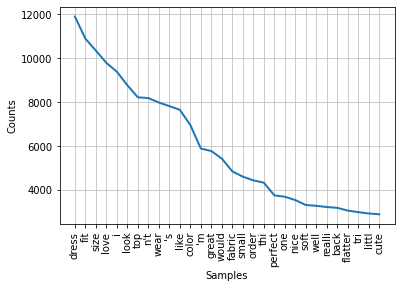

In [11]:
# Visualize the frequency of words in reviews
fdistReview = FreqDist(flattenedCorpusReview)
print(fdistReview)

# Plot the frequency of review words
fdistReview.plot(30,cumulative=False)
plt.show()

<FreqDist with 20065 samples and 658674 outcomes>


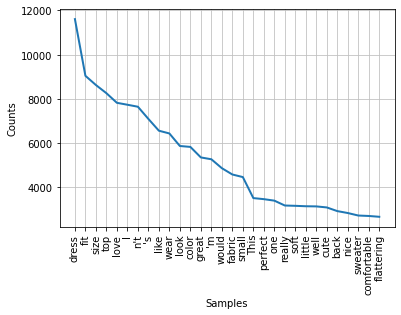

In [12]:
# Visualize the frequency of words in reviews
fdistTitle = FreqDist(flattenedCorpusTitle)
print(fdistTitle)

# Plot the frequency of review words
fdistTitle.plot(30,cumulative=False)
plt.show()

## Section 4 | Bag of Words

### Making Bag of Words Model

In [13]:
# Bag of Words Model for Reviews
cvr = CountVectorizer(lowercase=True,ngram_range = (1,1))
trainingReview = cvr.fit_transform(filteredCorpusReview).toarray()

# Bag of Words Model for Titles
cvt = CountVectorizer(lowercase=True,ngram_range = (1,1))
trainingTitle = cvt.fit_transform(filteredCorpusTitle).toarray()

In [14]:
# Create a dataframe to visualize the review bag of words
dfReviews = pd.DataFrame(data=trainingReview,columns = cvr.get_feature_names_out())
dfReviews.head()

00  00p  03dd  0dd  0in  0p  0petit  0petite  0r  0veral  ...  zippers  \
0   0    0     0    0    0   0       0        0   0       0  ...        0   
1   0    0     0    0    0   0       0        0   0       0  ...        0   
2   0    0     0    0    0   0       0        0   0       0  ...        0   
3   0    0     0    0    0   0       0        0   0       0  ...        0   
4   0    0     0    0    0   0       0        0   0       0  ...        0   

   zippie  zipping  zips  zombi  zone  zooland  zoom  zuma  ã¼ber  
0       0        0     0      0     0        0     0     0      0  
1       0        0     0      0     0        0     0     0      0  
2       0        0     0      0     0        0     0     0      0  
3       0        0     0      0     0        0     0     0      0  
4       0        0     0      0     0        0     0     0      0  

[5 rows x 13073 columns]

In [15]:
# Create a dataframe to visualize the titles bag of words
dfTitles = pd.DataFrame(data=trainingTitle,columns = cvt.get_feature_names_out())
dfTitles.head()

00  00p  03dd  0dd  0in  0p  0petite  0r  0verall  0xs  ...  zipping  zips  \
0   0    0     0    0    0   0        0   0        0    0  ...        0     0   
1   0    0     0    0    0   0        0   0        0    0  ...        0     0   
2   0    0     0    0    0   0        0   0        0    0  ...        0     0   
3   0    0     0    0    0   1        0   0        0    0  ...        0     0   
4   0    0     0    0    0   0        0   0        0    0  ...        0     0   

   zoe  zombi  zone  zoolander  zoom  zowie  zuma  ã¼ber  
0    0      0     0          0     0      0     0      0  
1    0      0     0          0     0      0     0      0  
2    0      0     0          0     0      0     0      0  
3    0      0     0          0     0      0     0      0  
4    0      0     0          0     0      0     0      0  

[5 rows x 14489 columns]

### Bag of Words Trial Run With User Generated Ratings

In [16]:
# Make a training and testing set for reviews
X_train, X_test, y_train, y_test = train_test_split(trainingReview, reviews['Rating'], test_size=0.3, random_state = 1) 

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("Bag of Words Review Accuracy:",metrics.accuracy_score(y_test, predicted))

Bag of Words Review Accuracy: 0.623066725585506


In [17]:
# Make a training and testing set for titles
X_train, X_test, y_train, y_test = train_test_split(trainingTitle, titles['Rating'], test_size=0.3, random_state = 1)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("Bag of Words Title Accuracy:",metrics.accuracy_score(y_test, predicted))

Bag of Words Title Accuracy: 0.6240040684861841


### Making TF-IDF Model

In [18]:
tfReviews = TfidfVectorizer()
review_tf = tfReviews.fit_transform(filteredCorpusReview).toarray()

tfTitles = TfidfVectorizer()
title_tf = tfTitles.fit_transform(filteredCorpusTitle).toarray()

In [19]:
# Create a dataframe to visualize the review TF-IDF
dfReviews = pd.DataFrame(data=review_tf,columns = tfReviews.get_feature_names_out())
dfReviews.head()

00  00p  03dd  0dd  0in   0p  0petit  0petite   0r  0veral  ...  zippers  \
0  0.0  0.0   0.0  0.0  0.0  0.0     0.0      0.0  0.0     0.0  ...      0.0   
1  0.0  0.0   0.0  0.0  0.0  0.0     0.0      0.0  0.0     0.0  ...      0.0   
2  0.0  0.0   0.0  0.0  0.0  0.0     0.0      0.0  0.0     0.0  ...      0.0   
3  0.0  0.0   0.0  0.0  0.0  0.0     0.0      0.0  0.0     0.0  ...      0.0   
4  0.0  0.0   0.0  0.0  0.0  0.0     0.0      0.0  0.0     0.0  ...      0.0   

   zippie  zipping  zips  zombi  zone  zooland  zoom  zuma  ã¼ber  
0     0.0      0.0   0.0    0.0   0.0      0.0   0.0   0.0    0.0  
1     0.0      0.0   0.0    0.0   0.0      0.0   0.0   0.0    0.0  
2     0.0      0.0   0.0    0.0   0.0      0.0   0.0   0.0    0.0  
3     0.0      0.0   0.0    0.0   0.0      0.0   0.0   0.0    0.0  
4     0.0      0.0   0.0    0.0   0.0      0.0   0.0   0.0    0.0  

[5 rows x 13073 columns]

In [20]:
# Create a dataframe to visualize the titles TF-IDF
dfTitles = pd.DataFrame(data=title_tf,columns = tfTitles.get_feature_names_out())
dfTitles.head()

00  00p  03dd  0dd  0in        0p  0petite   0r  0verall  0xs  ...  \
0  0.0  0.0   0.0  0.0  0.0  0.000000      0.0  0.0      0.0  0.0  ...   
1  0.0  0.0   0.0  0.0  0.0  0.000000      0.0  0.0      0.0  0.0  ...   
2  0.0  0.0   0.0  0.0  0.0  0.000000      0.0  0.0      0.0  0.0  ...   
3  0.0  0.0   0.0  0.0  0.0  0.183864      0.0  0.0      0.0  0.0  ...   
4  0.0  0.0   0.0  0.0  0.0  0.000000      0.0  0.0      0.0  0.0  ...   

   zipping  zips  zoe  zombi  zone  zoolander  zoom  zowie  zuma  ã¼ber  
0      0.0   0.0  0.0    0.0   0.0        0.0   0.0    0.0   0.0    0.0  
1      0.0   0.0  0.0    0.0   0.0        0.0   0.0    0.0   0.0    0.0  
2      0.0   0.0  0.0    0.0   0.0        0.0   0.0    0.0   0.0    0.0  
3      0.0   0.0  0.0    0.0   0.0        0.0   0.0    0.0   0.0    0.0  
4      0.0   0.0  0.0    0.0   0.0        0.0   0.0    0.0   0.0    0.0  

[5 rows x 14489 columns]

### TF-IDF Trial Run With User Generated Ratings

In [21]:
# Make a training and testing set for reviews
X_train, X_test, y_train, y_test = train_test_split(review_tf, reviews['Rating'], test_size=0.3, random_state=123)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("TF-IDF df Review Accuracy:",metrics.accuracy_score(y_test, predicted))

TF-IDF df Review Accuracy: 0.5554573574900574


In [22]:
# Make a training and testing set for titles
X_train, X_test, y_train, y_test = train_test_split(title_tf, titles['Rating'], test_size=0.3, random_state=123)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("TF-IDF Title Accuracy:",metrics.accuracy_score(y_test, predicted))

TF-IDF Title Accuracy: 0.5511103576877436


## Section 5 | Generate Sentiment and Polarity

In [23]:
# Helps map sentiment values to rating values
def map(value, minFrom, maxFrom, minTo, maxTo):
    return (value - minFrom) * (maxTo - minTo) / (maxFrom - minFrom) + minTo

def map_sentiment(sentiment):
    neg = -sentiment['neg']
    pos = sentiment['pos']
    neu = sentiment['neu']
    return (neu + pos + neg)*5
    

In [24]:
polarityReviews = []
sentimentRatingReviews = []
# Find the sentiment of each review
for review in filteredCorpusReview:
    polarityReviews.append(TextBlob(review).sentiment.polarity)
    sentimentRatingReviews.append(int(round(map(polarityReviews[-1], -1, 1, 1, 5))))
    # Map the sentiment values to rating values
    # filteredReviewScores.append(int(round(map(ss['compound'], -1, 1, 1, 5))))
reviews['Polarity'] = polarityReviews
reviews['SentimentRating'] = sentimentRatingReviews

In [25]:
# Find the sentiment of each title
polarityTitles = []
sentimentRatingTitles = []
#filteredTitleScores = []
for title in filteredCorpusTitle:
    polarityTitles.append(TextBlob(title).sentiment.polarity)
    sentimentRatingTitles.append(int(round(map(polarityTitles[-1], -1, 1, 1, 5))))
    #ss = sid.polarity_scores(title)
    # Map the sentiment values to rating values
    # filteredTitleScores.append(int(round(map(ss['compound'], -1, 1, 1, 5))))
    #filteredTitleScores.append(int(round(map_sentiment(ss))))
#titles['Sentiment'] = filteredTitleScores
titles['Polarity'] = polarityTitles
titles['SentimentRating'] = sentimentRatingTitles

In [26]:
reviews.head()

id  Age                                        Review Text  Rating  \
0   0   33  Absolutely wonderful - silky and sexy and comf...       4   
1   1   34  Love this dress!  it's sooo pretty.  i happene...       5   
2   2   60  I had such high hopes for this dress and reall...       3   
3   3   50  I love, love, love this jumpsuit. it's fun, fl...       5   
4   4   47  This shirt is very flattering to all due to th...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   

  Class Name  Polarity  SentimentRating  
0  Intimates  0.633333                4  
1    Dresses  0.318750                4  
2    Dresses  0.069412                3  
3      Pants  0.520000                4  
4    Blouses  0.458333                4

In [27]:
titles.head()

id  Age                                        Review Text  Rating  \
2   2   60  Some major design flaws I had such high hopes ...       3   
3   3   50  My favorite buy! I love, love, love this jumps...       5   
4   4   47  Flattering shirt This shirt is very flattering...       5   
5   5   49  Not for the very petite I love tracy reese dre...       2   
6   6   39  Cagrcoal shimmer fun I aded this in my basket ...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   
5                0                        4         General         Dresses   
6                1                        1  General Petite            Tops   

  Class Name  Polarity  SentimentRating  
2    Dresses  0.069006                3  
3      Pants  0.520000                4  
4    Blouses  0.458333                4  
5    Dresses  0.150000                3  
6      Knits  0.120500                3

### Visualizing Sentiment

#### Polarity Comparisons

In [28]:
px.histogram(reviews, x="Polarity", title="Polarity of Reviews Without Titles")

In [54]:

px.histogram(titles, x="Polarity", title="Polarity of Reviews with Titles")

In [30]:
fig = go.Figure(data=go.Histogram(x=reviews['Polarity'], name='Without Titles'), layout=go.Layout(title='Comparison of Review Polarity with Titles vs. Without Titles'))
fig.add_trace(go.Histogram(x=titles['Polarity'], name="With Titles"))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [46]:
posPolarity = titles[titles['Positive Feedback Count'] > 0]
negPolarity = titles[titles['Positive Feedback Count'] == 0]
fig = go.Figure(data=go.Histogram(x=posPolarity['Polarity'], name='Positive Feedback'), layout=go.Layout(title='Polarity of Reviews with Positive Feedback'))
fig.add_trace(go.Histogram(x=negPolarity['Polarity'], name="No Positive Feedback"))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [50]:
recommended = titles[titles['Recommended IND'] > 0]
notRecommended = titles[titles['Recommended IND'] == 0]
fig = go.Figure(data=go.Histogram(x=recommended['Polarity'], name='Recommended'), layout=go.Layout(title='Polarity of Reviews That Recommmended The Product'))
fig.add_trace(go.Histogram(x=notRecommended['Polarity'], name="Not Recommended"))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

#### Sentiment Rating vs. User Rating

In [31]:
fig = go.Figure(data=go.Histogram(x=reviews['SentimentRating'], name='Sentiment Rating'), layout=go.Layout(title='Sentiment Rating vs. User Rating | Without Titles'))
fig.add_trace(go.Histogram(x=reviews['Rating'], name="User Rating"))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [32]:
fig = go.Figure(data=go.Histogram(x=titles['SentimentRating'], name='Sentiment Rating'), layout=go.Layout(title='Sentiment Rating vs. User Rating | With Titles'))
fig.add_trace(go.Histogram(x=titles['Rating'], name="User Rating"))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

#### Correlation Heatmap

<AxesSubplot:>

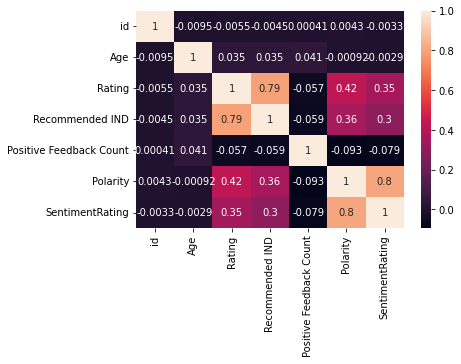

In [61]:
sns.heatmap(titles.corr(),annot =True)

#### Review Samples Without Titles

In [69]:
samplePosReviews = reviews[reviews['Polarity'] > 0.60].sample(n=3)
sampleNegReviews = reviews[reviews['Polarity'] < -0.60].sample(n=3)
sampleNeuReviews = reviews[reviews['Polarity'] == 0.00].sample(n=3)

##### Positive Reviews

In [66]:
for i in range(3):
    print(samplePosReviews.iloc[i]['Review Text'])
    print("Polarity: ",samplePosReviews.iloc[i]['Polarity'],"\n")
samplePosReviews

This dress is perfection! very flattering and pretty.
Polarity:  1.0 

This is perfect if you are looking for comfort and style in the same bathing suit.
Polarity:  1.0 

I absolutely am obsessed with this poncho! it is the perfect piece for fall and so easy to layer.
Polarity:  1.0 



id  Age                                        Review Text  Rating  \
8855    8855   31  This dress is perfection! very flattering and ...       5   
14471  14471   47  This is perfect if you are looking for comfort...       5   
5298    5298   22  I absolutely am obsessed with this poncho! it ...       5   

       Recommended IND  Positive Feedback Count Division Name Department Name  \
8855                 1                        1       General         Dresses   
14471                1                        2     Initmates        Intimate   
5298                 1                        0       General            Tops   

       Class Name  Polarity  SentimentRating  
8855      Dresses       1.0                5  
14471        Swim       1.0                5  
5298   Fine gauge       1.0                5

##### Negative Reviews

In [70]:
for i in range(3):
    print(sampleNegReviews.iloc[i]['Review Text'])
    print("Polarity: ",sampleNegReviews.iloc[i]['Polarity'],"\n")
sampleNegReviews

I'd been wanting the blouse for quite a while but hesitated based on reading reviews. when it went on sale i thought i'd try but it was like a tent on me. the fabric was pretty but just hung without any resemblance to photo. too bad because the color was gorgeous & could have been a favorite of looked like photo.
Polarity:  -0.75 

This product has a terrible zipper that ultimately caused me to return the dress. it's pretty bad when it won't even zip up on the hanger. such a beautiful dress; it broke my heart!
Polarity:  -0.6999999999999998 

This dress is so beautiful in person. it is not overly flowy, well made and extremely feminine. i really have not a bad word to say about it. and on sale, it's a steal. i plan to wear mine with tall boots as shown and with my cowboy boots.
Polarity:  -0.6999999999999998 



id  Age                                        Review Text  Rating  \
16830  16830   52  I'd been wanting the blouse for quite a while ...       3   
19159  19159   34  This product has a terrible zipper that ultima...       1   
8932    8932   42  This dress is so beautiful in person. it is no...       5   

       Recommended IND  Positive Feedback Count Division Name Department Name  \
16830                0                        1       General            Tops   
19159                0                        0       General         Dresses   
8932                 1                        0       General         Dresses   

      Class Name  Polarity  SentimentRating  
16830    Blouses     -0.75                2  
19159    Dresses     -0.70                2  
8932     Dresses     -0.70                2

##### Neutral Reviews

In [68]:
for i in range(3):
    print(sampleNeuReviews.iloc[i]['Review Text'])
    print("Polarity: ",sampleNeuReviews.iloc[i]['Polarity'],"\n")
sampleNeuReviews

I'm pear-shaped so my inclination is to always grab an a-line/fit-n-flare style dress or skirt. but for some reason this stood out to me and i'm glad i tried it on. i love this dress! i'm 5'9 with a longer torso and this still went down to my knees so it definitely works for taller girls. the cut is so flattering and, along with the thicker material, it gives me more of an hourglass shape that enhances my curves instead of making me want to camouflage them. i got my dress in a size 6 and it's tt
Polarity:  0.5 

What a find! this skirt is so soft and fits like a dream. perfect shape and length. i've been looking for more pieces to match a couple of fabulous pairs of purple shoes i have, so this is just the ticket!
Polarity:  0.5 

I bought this top after seeing it featured on a style blog. i was really excited to wear it until i realized how see thru it was. i had to put a cami underneath which detracted from the beauty of the top. even my flesh toned bra showed thru so i sadly had to 

id  Age                                        Review Text  Rating  \
19757  19757   32  I'm pear-shaped so my inclination is to always...       5   
3222    3222   33  What a find! this skirt is so soft and fits li...       5   
3371    3371   33  I bought this top after seeing it featured on ...       4   

       Recommended IND  Positive Feedback Count   Division Name  \
19757                1                        4         General   
3222                 1                        0         General   
3371                 0                        3  General Petite   

      Department Name Class Name  Polarity  SentimentRating  
19757         Dresses    Dresses       0.5                4  
3222          Bottoms     Skirts       0.5                4  
3371             Tops    Blouses       0.5                4

In [79]:
negative = (len(reviews.loc[reviews['Polarity'] < -0.35]['Review Text'].values) / len(reviews['Review Text']))*100
positive = (len(reviews.loc[reviews['Polarity'] > 0.35]['Review Text'].values) / len(reviews['Review Text']))*100
neutral = (len(reviews.loc[reviews['Polarity'] >= -0.35]['Review Text'].values) - len(reviews.loc[reviews['Polarity'] <= 0.35]['Review Text'].values)) / len(reviews['Review Text'])*100


([<matplotlib.patches.Wedge at 0x1eb17928670>,
 [Text(6.735557395310444e-17, 1.1, 'Positive'),
  Text(-1.0999226781551776, -0.013042318810006863, 'Negative'),
  Text(0.013042361451071505, -1.099922677649561, 'Neutral')])

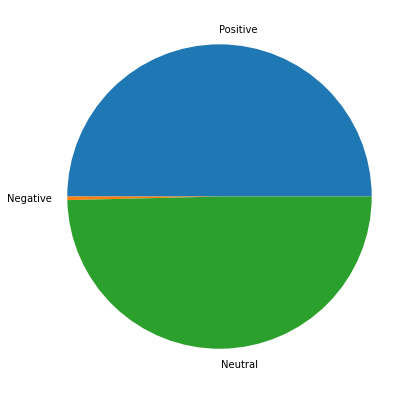

In [84]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(10,7))
plt.pie([positive,negative,neutral], labels = ['Positive','Negative','Neutral']) 

#### Review Samples With Titles

In [37]:
samplePosTitle = titles[titles['Polarity'] > 0.60].sample(n=3)
sampleNegTitle = titles[titles['Polarity'] < -0.60].sample(n=3)
sampleNeuTitle = titles[titles['Polarity'] == 0.00].sample(n=3)

##### Positive Reviews

In [38]:
for i in range(3):
    print(samplePosTitle.iloc[i]['Review Text'])
    print("Polarity: ",samplePosTitle.iloc[i]['Polarity'],"\n")
samplePosTitle

Beautiful fabric This too is so beautiful in person. there is gold dots all over the blouse that are not overwhelming. i love this top with business attire and denim. fits tts.
Polarity:  0.64 

Perfect shirt!!! I love this shirt. it is great quality and hangs perfectly! please make more colors in this one. i would buy all of them!!
Polarity:  0.825 

Versatile top This top is great for layering or by itself over skinny jeans or leggings! i'm 5'5 and this is the perfect length! ??????
Polarity:  0.7 



id  Age                                        Review Text  Rating  \
341    341   40  Beautiful fabric This too is so beautiful in p...       5   
7741  7741   47  Perfect shirt!!! I love this shirt. it is grea...       5   
7203  7203   53  Versatile top This top is great for layering o...       5   

      Recommended IND  Positive Feedback Count   Division Name  \
341                 1                        0         General   
7741                1                        0  General Petite   
7203                1                        0         General   

     Department Name Class Name  Polarity  SentimentRating  
341             Tops    Blouses     0.640                4  
7741            Tops    Blouses     0.825                5  
7203            Tops      Knits     0.700                4

##### Negative Reviews

In [39]:
for i in range(3):
    print(sampleNegTitle.iloc[i]['Review Text'])
    print("Polarity: ",sampleNegTitle.iloc[i]['Polarity'],"\n")
sampleNegTitle

A gorgeous dress This dress is so beautiful in person. it is not overly flowy, well made and extremely feminine. i really have not a bad word to say about it. and on sale, it's a steal. i plan to wear mine with tall boots as shown and with my cowboy boots.
Polarity:  -0.6999999999999998 

Save your money What a disappointment and for the price, it's outrageous!
Polarity:  -0.8 

Terrible quality cut Cut out design, no seems or hems.
 very disappointed in retailer
Polarity:  -0.875 



id  Age                                        Review Text  Rating  \
8932    8932   42  A gorgeous dress This dress is so beautiful in...       5   
5114    5114   52  Save your money What a disappointment and for ...       1   
14754  14754   52  Terrible quality cut Cut out design, no seems ...       1   

       Recommended IND  Positive Feedback Count Division Name Department Name  \
8932                 1                        0       General         Dresses   
5114                 0                        1       General            Tops   
14754                0                        0       General            Tops   

      Class Name  Polarity  SentimentRating  
8932     Dresses    -0.700                2  
5114       Knits    -0.800                1  
14754      Knits    -0.875                1

##### Neutral Reviews

In [40]:
for i in range(3):
    print(sampleNeuTitle.iloc[i]['Review Text'])
    print("Polarity: ",sampleNeuTitle.iloc[i]['Polarity'],"\n")
sampleNeuTitle

"go to" please offer a maxi for mature customers. Silhouette transcends many occasions.
Polarity:  0.0 

Flawed Cute skirt but i agree with the other reviewer. you can't get it on! i tried my skinny daughter tried no go!
Polarity:  0.0 

Pretty and flattering This dress is flattering and seems to be made well. the polka dots add interest. i am usually a 2 and did go up to a 4 in this. .
Polarity:  0.0 



id  Age                                        Review Text  Rating  \
18340  18340   50  "go to" please offer a maxi for mature custome...       5   
1946    1946   35  Flawed Cute skirt but i agree with the other r...       1   
3946    3946   41  Pretty and flattering This dress is flattering...       5   

       Recommended IND  Positive Feedback Count   Division Name  \
18340                1                        1  General Petite   
1946                 0                        3         General   
3946                 1                        0  General Petite   

      Department Name Class Name  Polarity  SentimentRating  
18340         Dresses    Dresses       0.0                3  
1946          Bottoms     Skirts       0.0                3  
3946          Dresses    Dresses       0.0                3

### Bag of Words Run With Sentiment Values

In [41]:
# make a training and testing set for reviews
X_train, X_test, y_train, y_test = train_test_split(trainingReview, reviews['SentimentRating'], test_size=0.3, random_state = 1) 

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("Bag of Words Review Sentiment Accuracy:",metrics.accuracy_score(y_test, predicted))

Bag of Words Review Sentiment Accuracy: 0.7663868021799971


In [42]:
# Make a training and testing set for titles
X_train, X_test, y_train, y_test = train_test_split(trainingTitle, titles['SentimentRating'], test_size=0.3, random_state = 1) 

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("Bag of Words Title Sentiment Accuracy:",metrics.accuracy_score(y_test, predicted))

Bag of Words Title Sentiment Accuracy: 0.7806407865739956


### TF-TDF Run With Sentiment Values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(review_tf, reviews['SentimentRating'], test_size=0.3, random_state=123)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("Tfidf Review Sentiment Accuracy:",metrics.accuracy_score(y_test, predicted))

Tfidf Review Sentiment Accuracy: 0.7411989983797319


In [44]:
X_train, X_test, y_train, y_test = train_test_split(title_tf, titles['SentimentRating'], test_size=0.3, random_state = 1)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("Tfidf Title Sentiment Accuracy:",metrics.accuracy_score(y_test, predicted))

Tfidf Title Sentiment Accuracy: 0.7360569588065774
